In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
# Set global font settings
plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams['figure.dpi'] = 300
from utils import make_da, valid2All, get_processed_da, rotate_and_crop

def getValidGrids(df):
    return (df['idx']-1).tolist()

def plot_yield_maps(
    maps_list, 
    angle=-30, 
    cmap="RdYlGn", 
    label="Yield (t/ha)", 
    ncols=2, 
    figsize_factor=(2.5, 4), # (width_per_col, height_per_row)
    vmin=None, 
    vmax=None
):
    """
    Plots a list of yield maps side-by-side or in a grid.
    
    Args:
        maps_list (list): List of dicts, e.g., [{'da': da1, 'title': '2017'}, ...]
        angle (float): Rotation angle for the map.
        cmap (str): Colormap name.
        label (str): Colorbar label.
        ncols (int): Number of columns in the grid.
        figsize_factor (tuple): Scaling factor for figure size (w, h).
        vmin (float, optional): Min value for color scaling. Calculated automatically if None.
        vmax (float, optional): Max value for color scaling. Calculated automatically if None.
    """
    
    # 1. Calculate Grid Dimensions
    n_maps = len(maps_list)
    nrows = int(np.ceil(n_maps / ncols))
    
    # 2. Setup Figure
    fig, axes = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(ncols * figsize_factor[0], nrows * figsize_factor[1]), 
        constrained_layout=True
    )
    
    # Normalize axes to a flat list for iteration
    if n_maps == 1:
        axes_flat = [axes]
    else:
        axes_flat = axes.flatten()

    # 3. Calculate Global Scale (if not provided)
    # This ensures colors are comparable across all maps
    if vmin is None or vmax is None:
        all_vals = []
        for item in maps_list:
            all_vals.append(item['da'].values.flatten())
        
        flat_vals = np.concatenate(all_vals)
        valid_vals = flat_vals[~np.isnan(flat_vals)]
        
        if len(valid_vals) > 0:
            # Calculate percentiles to avoid outliers
            calc_vmin, calc_vmax = np.percentile(valid_vals, 2), np.percentile(valid_vals, 98)
        else:
            calc_vmin, calc_vmax = 0, 1
            
        vmin = vmin if vmin is not None else calc_vmin
        vmax = vmax if vmax is not None else calc_vmax

    # 4. Plotting Loop
    im = None # Placeholder for the image object (for colorbar)
    
    for i, ax in enumerate(axes_flat):
        if i < n_maps:
            item = maps_list[i]
            
            # Rotate the IMAGE ARRAY directly
            img_data = rotate_and_crop(item["da"], angle=angle)
            
            # Plot
            im = ax.imshow(
                img_data,
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                origin='lower',
                aspect='equal'
            )
            
            ax.set_title(item["title"], fontsize=12, fontweight='bold', pad=10)
            
            # Styling: Hide frames and ticks
            ax.set_frame_on(False)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # Hide unused subplots entirely
            ax.axis('off')

    # 5. Add Shared Colorbar
    if im:
        # Attach colorbar to the list of axes to center it
        cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.75, pad=0.05, aspect=30)
        cbar.set_label(label, size=11, fontweight='bold')
        cbar.ax.tick_params(labelsize=9)

    return fig, axes


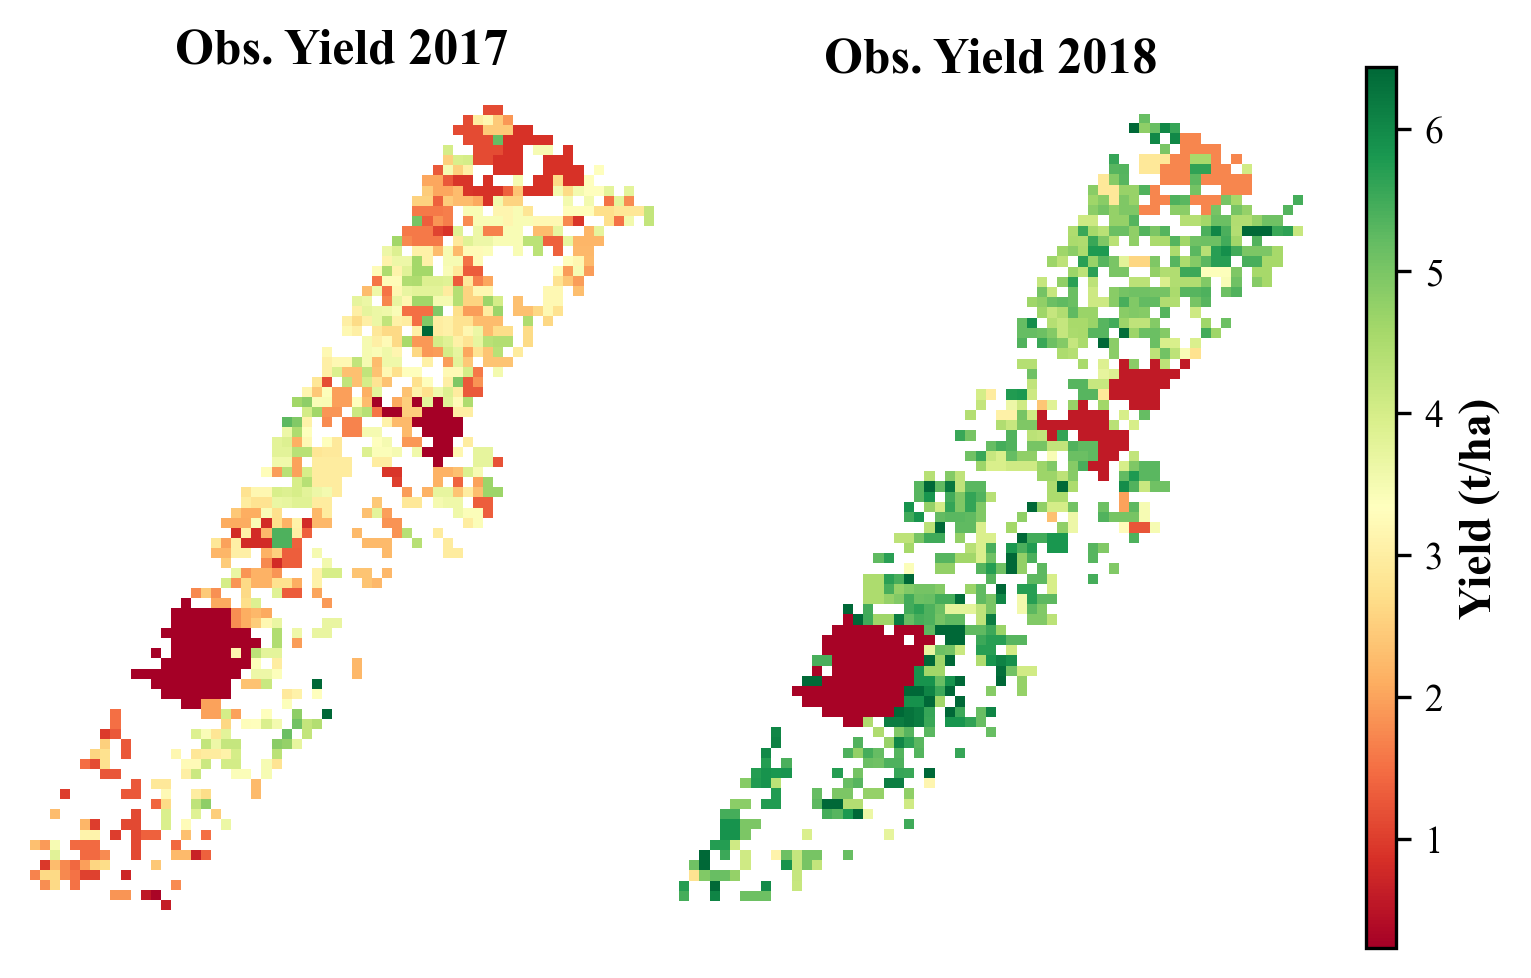

In [2]:
# plot yield ground turth
df_coords = pd.read_csv(f'Coords/Grid_geo_center_coordinates.csv')
df_obs_yield2017 = pd.read_csv(f'Estimated_yield_maps/Grid_level_groundtruth_yield/Grid_yield_measurement_2017.txt', sep=r'\s+')
df_obs_yield2018 = pd.read_csv(f'Estimated_yield_maps/Grid_level_groundtruth_yield/Grid_yield_measurement_2018.txt', sep=r'\s+')

# --- 2. Process DataArrays ---
# Note: Corrected variable usage for 2018
da2017 = get_processed_da(df_obs_yield2017, date_col='value', valid_idx=getValidGrids(df_obs_yield2017), df_coords=df_coords)
da2018 = get_processed_da(df_obs_yield2018, date_col='value', valid_idx=getValidGrids(df_obs_yield2018), df_coords=df_coords)

# --- 3. Prepare Plot Items ---
plot_items = [
    {"da": da2017, "title": "Obs. Yield 2017"},
    {"da": da2018, "title": "Obs. Yield 2018"}
]

# --- 4. Call the Plotting Function ---
plot_yield_maps(
    plot_items, 
    angle=0, 
    cmap="RdYlGn", 
    label="Yield (t/ha)",
    ncols=2
)

plt.show()

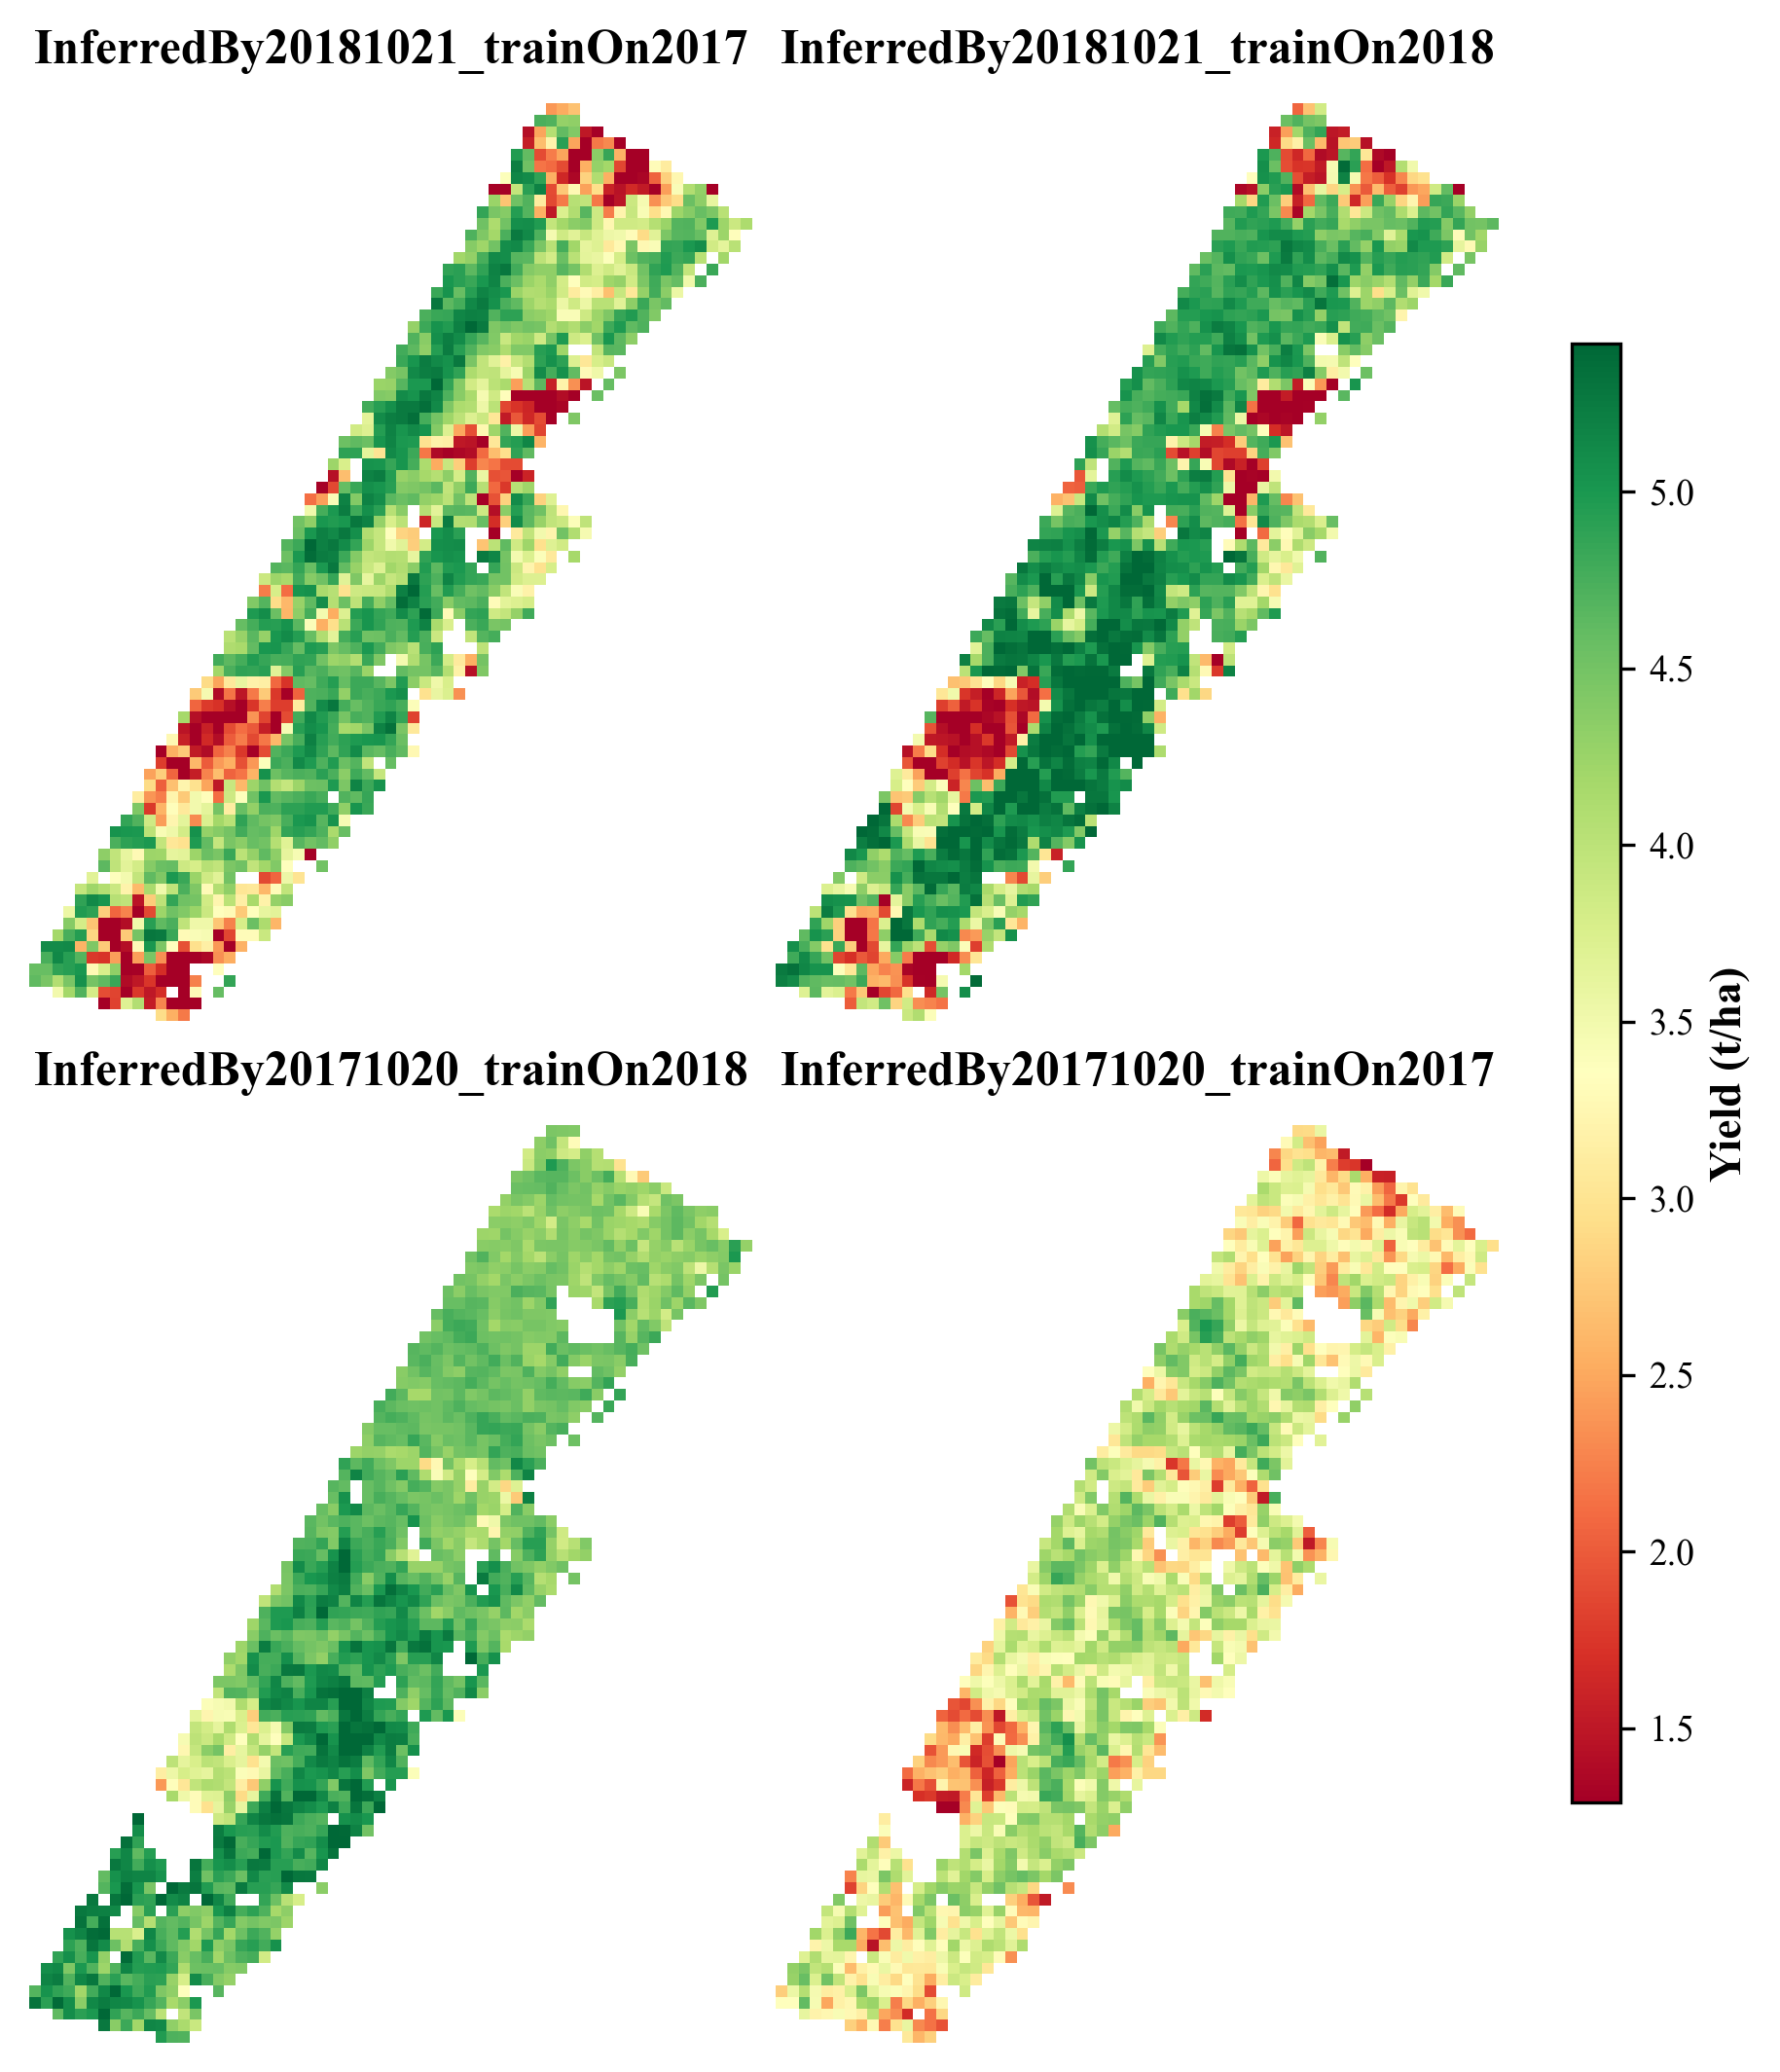

In [3]:
# plot yield inferred by the pure computer vision model
df_coords = pd.read_csv(f'Coords/Grid_geo_center_coordinates.csv')
valid = np.loadtxt('Estimated_crop_trait_maps/validGrid.txt').astype(np.int32).tolist()

df_yield_dict = {}
caselist = ['InferredBy20181021_trainOn2017','InferredBy20181021_trainOn2018',
             'InferredBy20171020_trainOn2018','InferredBy20171020_trainOn2017']
for case in caselist:
    df_yield_pred = pd.read_csv(f'Estimated_yield_maps/Pure_computer_vision/{case}.txt', sep=r'\s+')
    df_yield_dict[case] = get_processed_da(df_yield_pred, date_col='pred', valid_idx=valid, df_coords=df_coords)

plot_items = []
for case in caselist:
    plot_items.append({
        "da": df_yield_dict[case],
        "title": case
        })

# plot
plot_yield_maps(
    plot_items, 
    angle=0,         # Set to -30 if you need the rotation from the previous plots
    cmap="RdYlGn", 
    label="Yield (t/ha)",
    ncols=2,
    figsize_factor=(3, 3.5) # Slightly larger factor to accommodate 4 plots
)

plt.show()

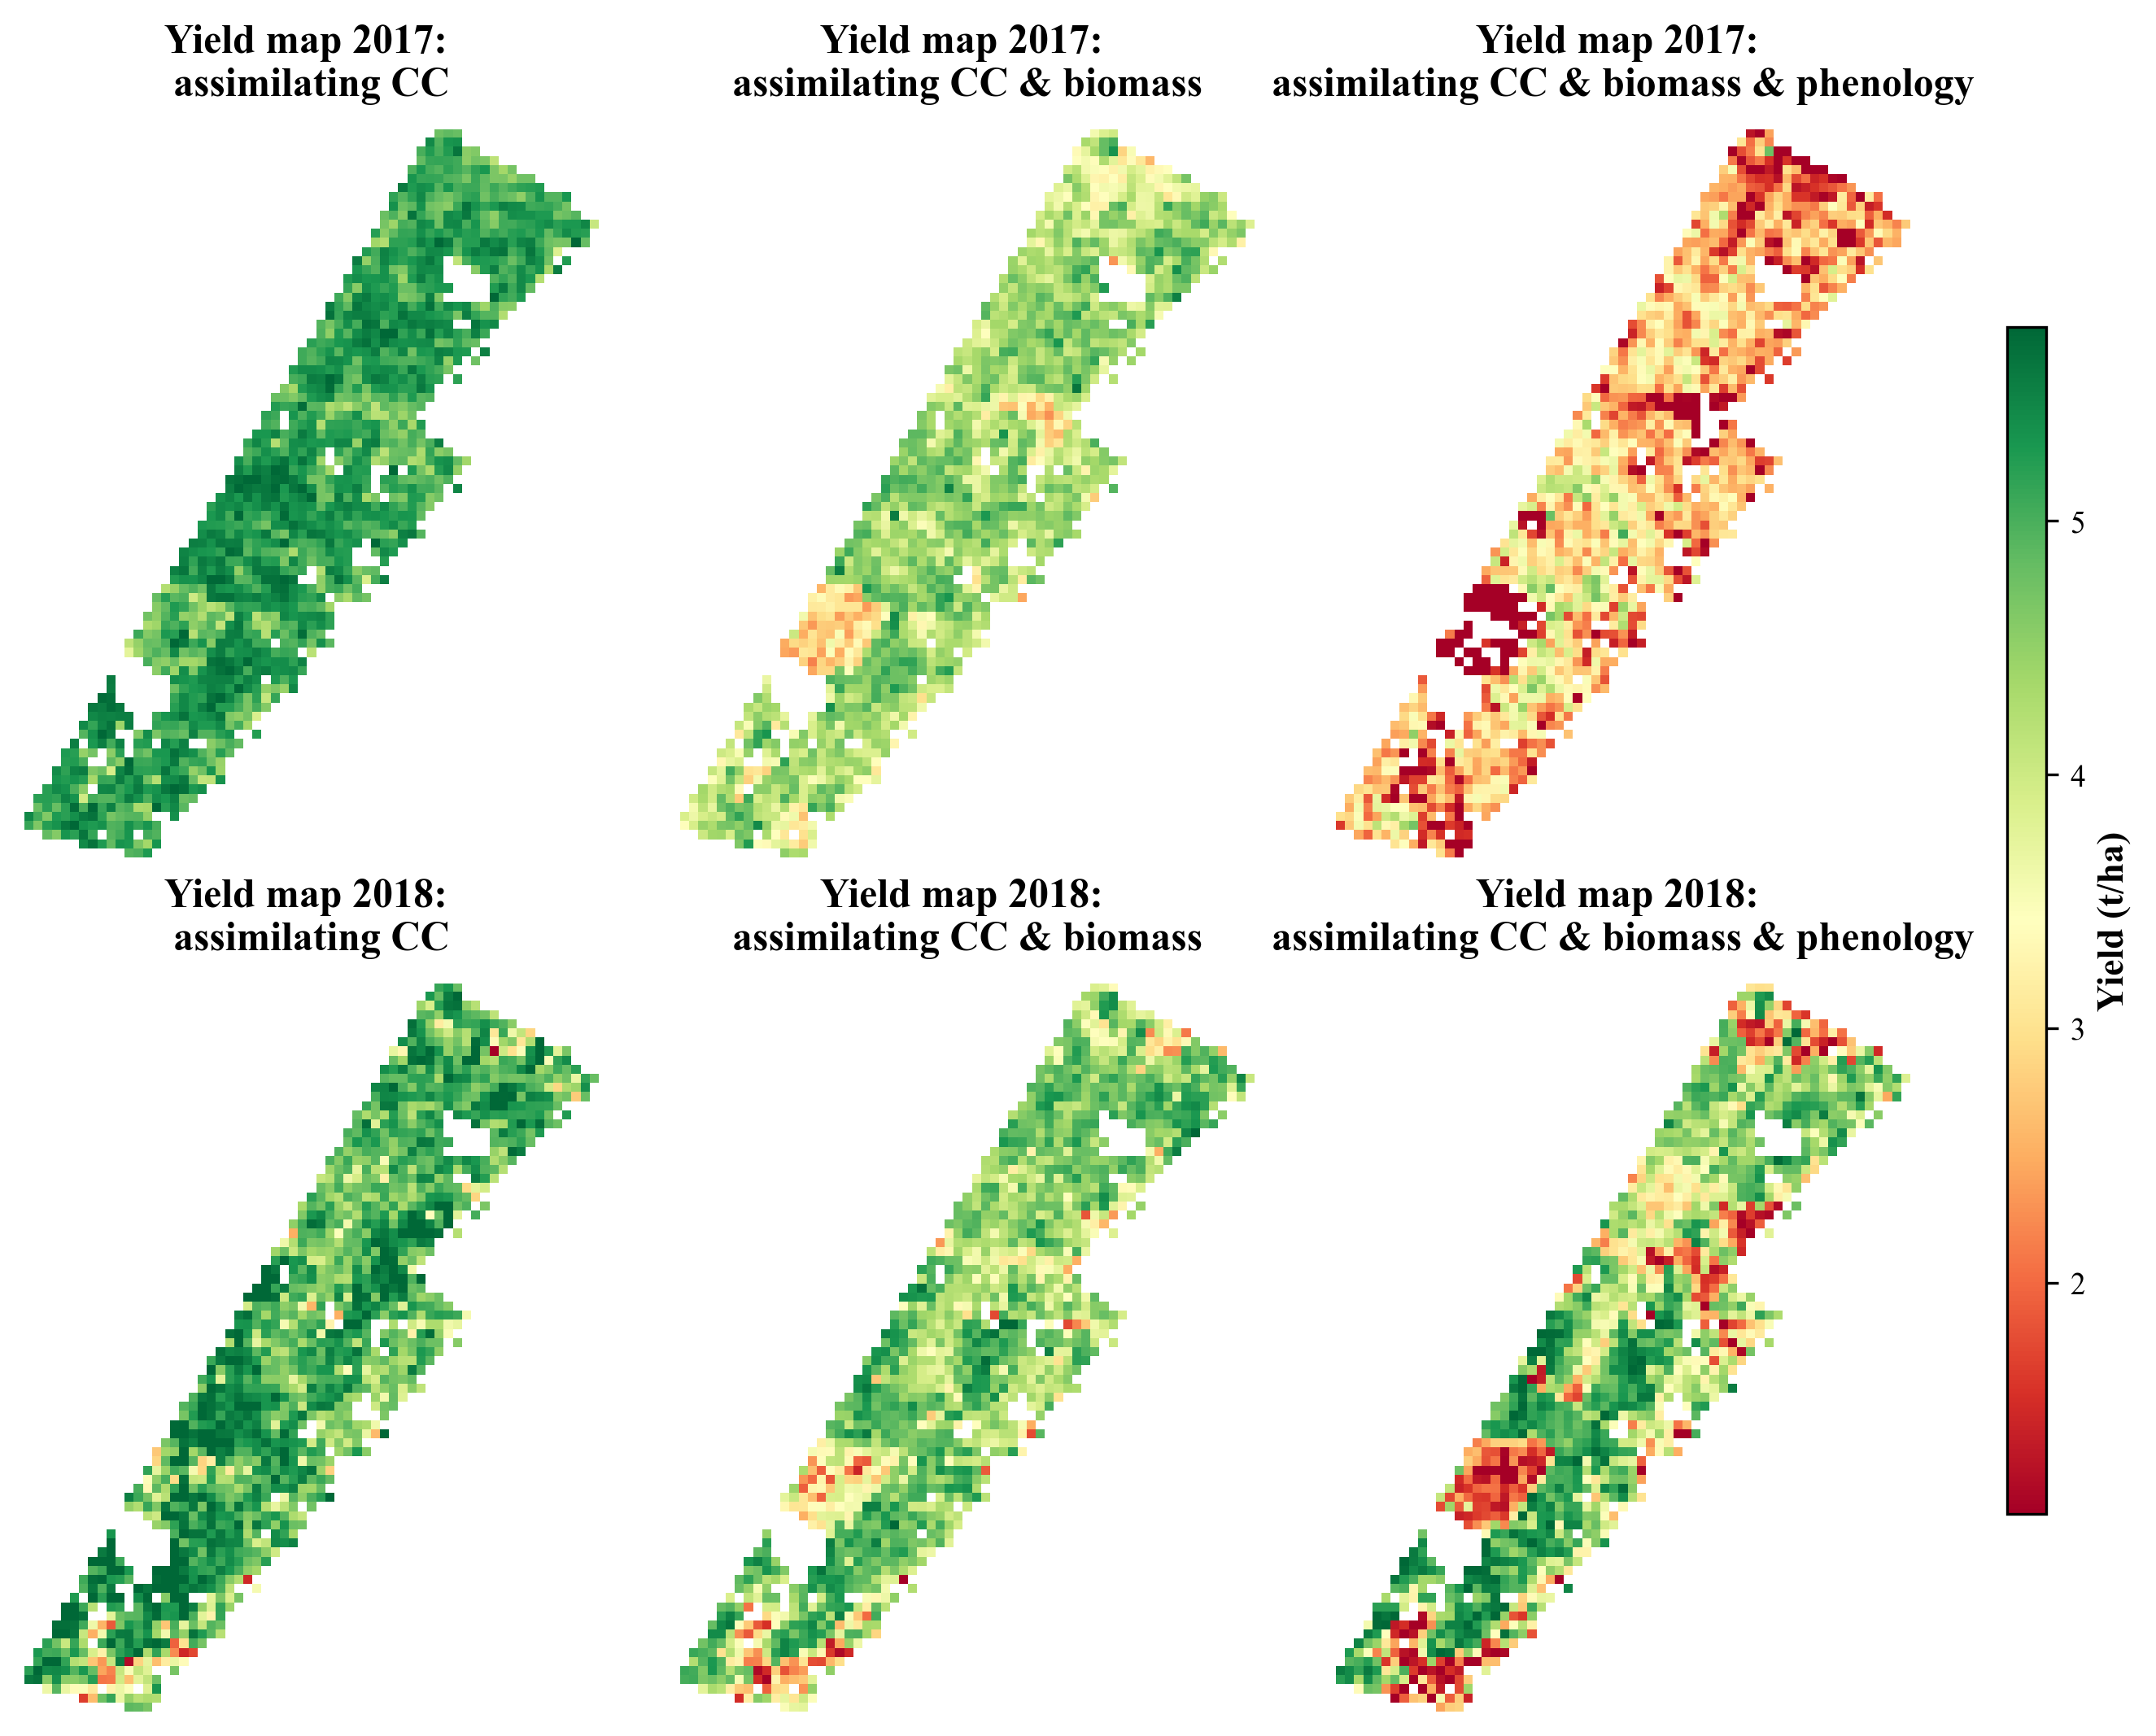

In [4]:
# plot yield predicted by the hybrid data assimilation system
df_coords = pd.read_csv(f'Coords/Grid_geo_center_coordinates.csv')
valid = np.loadtxt('Estimated_crop_trait_maps/validGrid.txt').astype(np.int32).tolist()

df_yield_dict = {}
caselist = ['obsAndPre_2017_1obs','obsAndPre_2017_2obs','obsAndPre_2017_3obs',
             'obsAndPre_2018_1obs','obsAndPre_2018_2obs','obsAndPre_2018_3obs']

labelmap = {'obsAndPre_2017_1obs':'Yield map 2017: \nassimilating CC',
            'obsAndPre_2017_2obs':'Yield map 2017: \nassimilating CC & biomass',
            'obsAndPre_2017_3obs':'Yield map 2017: \nassimilating CC & biomass & phenology',
            'obsAndPre_2018_1obs':'Yield map 2018: \nassimilating CC',
            'obsAndPre_2018_2obs':'Yield map 2018: \nassimilating CC & biomass',
            'obsAndPre_2018_3obs':'Yield map 2018: \nassimilating CC & biomass & phenology',}
for case in caselist:
    df_yield_pred = pd.read_csv(f'Estimated_yield_maps/Hybrid_data_assimilation/{case}.csv')

    df_yield_dict[case] = get_processed_da(df_yield_pred, date_col='pred', valid_idx=valid, df_coords=df_coords)

plot_items = []
for case in caselist:
    plot_items.append({
        "da": df_yield_dict[case],
        "title": labelmap[case]
        })

# plot
plot_yield_maps(
    plot_items, 
    angle=0,         # Set to -30 if you need the rotation from the previous plots
    cmap="RdYlGn", 
    label="Yield (t/ha)",
    ncols=3,
    figsize_factor=(3, 3.5) # Slightly larger factor to accommodate 4 plots
)

plt.show()